# <center>Music Prediction</center>


In this file, we use a neural network to predict the genre of music from 8 bars.

We copied a lot from Homework 4 because we have already done the work of creating neural networks.

In [2]:
# run this cell to import needed modules and define plotting functions (no input needed)
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import plotly
import plotly.graph_objects as go
import random, time
from collections import Counter
from sklearn.model_selection import train_test_split
import json
from sklearn.datasets import fetch_openml

# function to plot costs
def plot_costs(costs):
    plt.plot(costs)
    plt.xlabel("iterations")
    plt.ylabel("cost")
    plt.show()
    
# function to plot costs
def plot_grads(grads):
    plt.plot(grads)
    plt.xlabel("iterations")
    plt.ylabel("gradient norm")
    plt.show()

# defining a function to plot data
def plot_data(X,Y,size_ = 2):
    m = len(X)
    plot_figure = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=[r[0] for r in Y], mode='markers',marker=dict(size=size_))])
    plotly.offline.iplot(plot_figure)

# defining a function to plot models fit
def plot_fit(X,Y,W,B,G,size_ = 2):
    trace = go.Scatter3d(x=X[:,0], y=X[:,1], z=[r[0] for r in Y], mode='markers',marker=dict(size=size_))
    xs,ys = X[:,0],X[:,1]
    xxx = np.outer(np.linspace(min(xs), max(xs), 30), np.ones(30))
    yyy = np.outer(np.linspace(min(ys), max(ys), 30), np.ones(30)).T
    zzz = np.zeros([30,30])
    D = len(G)-1
    for i in range(30):
        for j in range(30):
            zzz[i,j] = feedforward(W,B,G,np.array([xxx[i,j],yyy[i,j]]))[D][0]
    # Configure the layout.
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    data = [trace,go.Surface(x=xxx, y=yyy, z=zzz, showscale=False, opacity=0.5)]
    # Render the plot.
    plot_figure = go.Figure(data=data, layout=layout)
    plot_figure.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=[min(X[:,0]),max(X[:,0])],),
            yaxis = dict(nticks=4, range=[min(X[:,1]),max(X[:,1])],),
            zaxis = dict(nticks=4, range=[min(Y),max(Y)],),),
        width=700,
        margin=dict(r=20, l=10, b=10, t=10))
    plotly.offline.iplot(plot_figure)

## Activation Functions

Here we define the functions `ReLU`, `Linear`, `Sigmoid`, `Squared`, and `Softmax`. They return the derivative or the correct output vector, depending on how they are called.

We also define the `loss` function with inputs `Nx`, `y`, `cost_type='se'`, and `deriv=False`, which will return the per-example loss function when `deriv=False` and returns the derivative when `deriv=True`. We will only use squared error cost, but `ce` and `bce` are defined here because it does not hurt to have.

In [3]:
def ReLU(x,deriv = False):
    if deriv:
        out = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] >= 0:
                out[i] = 1
            else:
                out[i] = 0
        return np.diagflat(out)
    else:
        return np.maximum(np.zeros(len(x)), x)

def Linear(x,deriv = False):
    if deriv:
        return np.diagflat(np.ones(len(x)))
    else:
        return x

def Sigmoid(x,deriv = False):
    if deriv:
        y=Sigmoid(x,deriv=False)
        return np.diagflat(y*(np.ones(y.shape) - y))
    else:
        out = np.zeros(len(x))
        for i in range(len(x)):
            out[i] = 1 / (1 + np.exp(-1 * x[i]))
        return np.array(out)

def Squared(x,deriv = False):
    if deriv:
        return np.diagflat(2 * x)
    else:
        out = np.zeros(len(x))
        for i in range(len(x)):
            out[i] = x[i] ** 2
        return out

def Softmax(x,deriv = False):
    totalSum = np.sum(np.exp(x))
    out = np.zeros(len(x))
    for i in range(len(x)):
        out[i] = np.exp(x[i]) / totalSum
    
    if deriv:
        return np.diagflat(out) - np.outer(out, out)
    else:
        return out

# Note: Nx and y are always numpy arrays (for 'bce' they always have only one entry)
# when deriv = False the output must be a number and when deriv = True the output must be a vector
def loss(Nx,y,cost_type,deriv = False):
    #print(f'Nx.shape={Nx.shape}, y.shape={y.shape}')
    if cost_type == "se":
        if deriv:
            return 2 * (Nx - y).T
        else:
            return (LA.norm(Nx-y,2))**2
    elif cost_type == "ce":
        if deriv:
            out = np.zeros(len(Nx))
            for i in range(len(Nx)):
                out[i] = 1/Nx[i]
            return np.array(-y).T @ np.diagflat(out)
        else:
            return np.array(-y).T @ np.log(Nx)
    elif cost_type == "bce":
        yVal = y[0]
        NxVal = Nx[0]
        if deriv:
            return (-yVal/NxVal) + (1-yVal)/(1-NxVal)
        else:
            return -yVal * np.log(NxVal) - (1-yVal) * np.log(1 - NxVal)

# Feedforward

Here, we define a function `feedforward(W,B,G,x)` where 

- `W` is a list of matrices with the property that `W[i+1].shape[1] == W[i].shape[0]` for all `i`
- `B` is a list of vectors with the property that `B[i].shape == W[i].shape[0]` for all `i`
- `G` is a list of activations with length `len(W)+1` where `G[i]` is a function which takes a numpy array of dimension `W[i].shape[0]` as input and gives a numpy array of the same dimension as output. We always take `g[0] = Linear` (usually we would not have an activation here at all but it is convenient to use `Linear` here just as a place holder. Think of it as being the same as not having an activation function at layer 0.)
- `x` is an input vector of dimension `W[0].shape[1]`

the output is a list `feeds` where `feeds[i]` is the pair `[xi,si]` where `x0 = x`, `s0 = W[0]@x+B[0]`, and for `i>0` we have `x(i+1) = G[i+1](si)` and `si = W[i]@xi+B[i]`. The last entry only has an `x` and no signal (this is the feedforward `Nx` of the network).

In [4]:
def feedforward(W,B,G,x):
    feeds = []
    feeds.append([G[0](x), W[0]@G[0](x) + B[0]])
    for i in range(1,len(W)):
        xi = G[i](feeds[i-1][1])
        si = W[i]@xi + B[i]
        feeds.append([xi,si])
        
    feeds.append(G[len(W)](feeds[len(W)-1][1]))
    return feeds

# Deltas

Here we define a function that computes the deltas as we have defined in class.

In [5]:
def deltas(X_feeds,Y,W,B,G,verbose = False, cost_type = 'se'):
    delta = {}
    D = len(W)
    for key in X_feeds.keys():
        y = Y[key]
        X = X_feeds[key]
        Nx = X[-1]
        delta[key] = [(loss(Nx, y, cost_type, deriv=True)) @ G[-1](X[D-1][1], deriv=True)]
        for j in range(D-1, 0, -1):
            delta[key].insert(0, delta[key][0] @ W[j] @ G[j](X[j-1][1], deriv=True))
    return delta

# Gradients

Here we approximate the gradient of the cost function with respect to the $W^{(l)}$s and $b^{(l)}$s, then return the feedforwards for each row of the data matrix (or the batches that we are using).

In [6]:
def grads(X,Y,W,B,G,batch, lambda_ = 0, verbose = False,cost_type = 'se'):
    dWs = []
    dBs = []
    batch_size = len(batch)
    
    X_feeds = {}
    for i in batch:
        X_feeds[i] = feedforward(W,B,G,X[i])
    
    X_deltas = deltas(X_feeds, Y, W, B, G, verbose, cost_type)
    
    for l in range(len(W)):
        dW = sum( [np.outer(X_deltas[i][l], X_feeds[i][l][0]) for i in batch] ) / batch_size + 2 * lambda_ * W[l]
        dB = sum( [X_deltas[i][l] for i in batch ]) / batch_size
        dWs.append(dW)
        dBs.append(dB)
    return dWs, dBs, X_feeds

# Neural Network implementation

And this is the fit function, which runs the neural network and prints out the cost 30 times, spread out evenly along `max_iters`.

In [7]:
#max_iters should be a multiple of 100
def fit(X,Y,arch,G,alpha = 1e-9, momentum = .01, batch_size = 100, 
        lambda_ = 0, max_iters = 100,verbose = False, cost_type = 'se',print_costs = True):
    W,B,VW,VB = [],[],[],[]
    D,m = len(G)-1,len(X)
    
    last = X.shape[1]
    if verbose:
        print(f'X.shape[1]={X.shape[1]}')
        print(f'Y.shape[1]={Y.shape[1]}')
        
    for l in range(D):
        # append initializations to W, B, VW, VB
        W.append(np.random.default_rng().normal(loc=0,scale=2/(last+arch[l]), size=(arch[l],last)))
        VW.append(np.zeros(W[l].shape))
        B.append(np.zeros(arch[l]))
        VB.append(np.zeros(B[l].shape))
        last = arch[l]
    epochs, costs, grad_norms = 0,[],[]
    
    while epochs <= max_iters:
        batch = random.sample(range(m),batch_size)
        dWs,dBs,feeds = grads(X,Y,W,B,G,batch,lambda_,verbose,cost_type)
        grad_norms.append(sum( [LA.norm(W[l],2) for l in range(D)] ) + sum( [LA.norm(B[l],2) for l in range(D)]))
        
        costs.append(sum( [loss(feeds[i][D][0],Y[i],cost_type) for i in batch] ))
        
        if epochs%(np.floor(max_iters/30))==0 and print_costs:
            print(f'epoch: {epochs}')
            print(f'           cost: {costs[-1]}')

        for l in range(D):
            VW[l] = momentum*VW[l] - alpha * dWs[l]
            VB[l] = momentum*VB[l] - alpha * dBs[l]
            W[l] = W[l] + VW[l]
            B[l] = B[l] + VB[l]
        
        epochs += 1
    return W,B,costs,grad_norms

# Music Prediction

The goal of this problem is the classify the music samples correctly. This is similar to the multiclass classifier used for the iris dataset, and our accuracy functions will actually be exactly the same.

In [8]:
def predict(W,B,G,x,output_type = 'number'):
    prediction = feedforward(W,B,G,x)[-1]
    if output_type == 'vector':
        out = np.zeros(prediction.shape[0])
        out[np.argmax(prediction)] = 1
        return out
    
    elif output_type == 'number':
        return np.argmax(prediction)
    
    elif output_type == 'probability':
        if prediction <0.5:
            return 0
        else:
            return 1

In [20]:
# grabs data from midi-synthesis/Data

# from sklearn.datasets import load_iris,load_digits
# data = load_iris()
# X = data.data
# Y = np.zeros((data.target.shape[0],3))
# for i in range(data.target.shape[0]):
#     Y[i] = np.zeros(3)
#     Y[i][data.target[i]]=1
X = np.array([[1], [2], [3]]) # data
Y = np.array([[0], [1], [2]]) # labels

Here we create validation and test sets using `sklearn`.

In [21]:
# creating validation and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4) # 0.25 x 0.8 = 0.2

And here we pick our architecture for our prediction model. We know that the last layer should have `Softmax` activation with (some number) of choices. We will use our prediction function to determine the accuracy later with `output_type = 'number'`.

In [23]:
arch = [1, 1, 1]
G = [Linear, Linear, Linear, Linear]
W,B,costs,grad_norms = fit(X_train,y_train,arch,G,alpha = 5e-2, 
                                momentum = .99,batch_size=1,lambda_=0,max_iters=100,cost_type='se')

epoch: 0
           cost: 0.0002451157969899821
epoch: 3
           cost: 3.8396338699806276e-05
epoch: 6
           cost: 7.534418707194934e-05
epoch: 9
           cost: 0.0002289262394582043
epoch: 12
           cost: 5.603775998549896e-05
epoch: 15
           cost: 4.6448228172608574e-05
epoch: 18
           cost: 0.00020804489809152018
epoch: 21
           cost: 7.278347569815102e-05
epoch: 24
           cost: 2.5280960352165286e-05
epoch: 27
           cost: 0.00018385201442815718
epoch: 30
           cost: 8.816597899680575e-05
epoch: 33
           cost: 1.072802226402266e-05
epoch: 36
           cost: 0.0001576743764809932
epoch: 39
           cost: 0.00010050338302494494
epoch: 42
           cost: 2.6698304568812596e-06
epoch: 45
           cost: 0.00013089772139227812
epoch: 48
           cost: 0.00010963313073459456
epoch: 51
           cost: 3.878090589246824e-09
epoch: 54
           cost: 0.00010455307506893096
epoch: 57
           cost: 0.00011475165172829465
epoch: 60
   

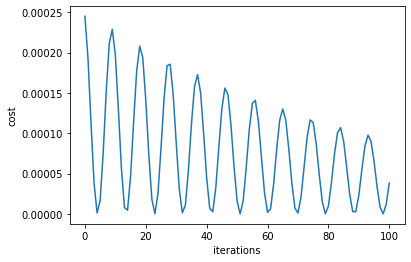

In [24]:
# plot the costs
plot_costs(costs)

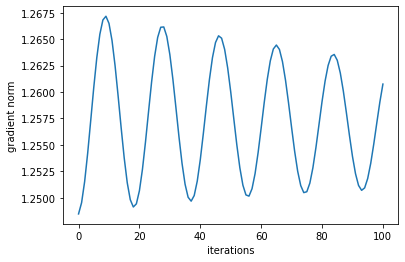

In [25]:
# plot the gradient norms
plot_grads(grad_norms)

## Measuring performance

Here we compute the accuracy of our model. We want high, and relatively the same values on training, validation, and test accuracy to know we have chosen a good architecture and dealt with regularization.

In [26]:
# compute training accuracy (write code to compute the accuracy of predictions on the training set)
correct_train = 0
for i in range(X_train.shape[0]):
    if all(predict(W,B,G,X_train[i]) == y_train[i]):
        correct_train += 1
        
train_accuracy = correct_train/X_train.shape[0]

In [27]:
# compute validation accuracy (write code to compute the accuracy of predictions on the validation set)
correct_val = 0
for i in range(X_val.shape[0]):
    if all(predict(W,B,G,X_val[i]) == y_val[i]):
        correct_val += 1
        
val_accuracy = correct_val/X_val.shape[0]

In [28]:
# compute test accuracy (write code to compute the accuracy of predictions on the test set)
correct_test = 0
for i in range(X_test.shape[0]):
    #print(predict(W,B,G,X[i]))
    if all(predict(W,B,G,X_test[i]) == y_test[i]):
        correct_test += 1
        
test_accuracy = correct_test/X_test.shape[0]

print(f'Training Accuracy:     {train_accuracy}')
print(f'Validation Accuracy:   {val_accuracy}')
print(f'Test Accuracy:         {test_accuracy}')

Training Accuracy:     0.0
Validation Accuracy:   0.0
Test Accuracy:         1.0
